Empirical coupling probability: 1.0000
Theoretical coupling probability: 0.0000
Total variation distance: 1.0000


/tmp/ipykernel_6710/1737098698.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_6710/1737098698.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



Plot saved as 'maximal_coupling_plot.pdf'


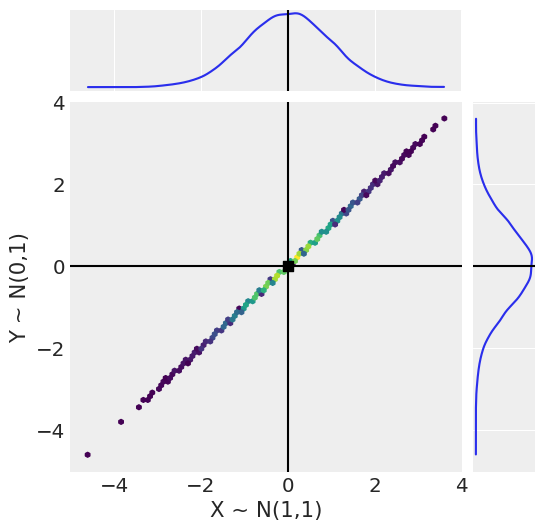

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import norm

# Set random seed for reproducibility
# np.random.seed(42)
az.style.use("arviz-darkgrid")


def maximal_coupling_normal(mu_p, sigma_p, mu_q, sigma_q, n_samples=10000):
    """
    Maximal coupling for two normal distributions using the alternative algorithm.
    p ~ N(mu_p, sigma_p^2), q ~ N(mu_q, sigma_q^2)
    """
    X = np.zeros(n_samples)
    Y = np.zeros(n_samples)
    coupled = np.zeros(n_samples, dtype=bool)

    for i in range(n_samples):
        # Sample X ~ p
        X[i] = np.random.normal(mu_p, sigma_p)

        # Compute acceptance probability for coupling
        p_x = stats.norm.pdf(X[i], mu_p, sigma_p)
        q_x = stats.norm.pdf(X[i], mu_q, sigma_q)

        # Try to couple
        W = np.random.rand()
        if W <= min(1, q_x / p_x):
            Y[i] = X[i]  # Accept coupling
            coupled[i] = True
        else:
            # Rejection sampling for Y
            while True:
                Y_star = np.random.normal(mu_q, sigma_q)
                W_star = np.random.rand()

                p_y = stats.norm.pdf(Y_star, mu_p, sigma_p)
                q_y = stats.norm.pdf(Y_star, mu_q, sigma_q)

                if W_star > p_y / q_y:
                    Y[i] = Y_star
                    break

    return X, Y, coupled


# Generate samples
mu_p, sigma_p = 0, 1  # p ~ N(1, 1)
mu_q, sigma_q = 0, 1  # q ~ N(0, 1)
n_samples = 10000

X, Y, coupled = maximal_coupling_normal(mu_p, sigma_p, mu_q, sigma_q, n_samples)

# Calculate coupling probability
coupling_prob = np.mean(coupled)

# Calculate theoretical coupling probability

tv_distance = 2 * norm.cdf(0, loc=-abs(mu_p - mu_q) / (2 * sigma_p), scale=1)
theoretical_coupling_prob = 1 - tv_distance

print(f"Empirical coupling probability: {coupling_prob:.4f}")
print(f"Theoretical coupling probability: {theoretical_coupling_prob:.4f}")
print(f"Total variation distance: {tv_distance:.4f}")

# Create ArviZ InferenceData object
# Reshape to have chain and draw dimensions
n_chains = 1
n_draws = n_samples

data = az.from_dict(
    posterior={
        "X ~ N(1,1)": X.reshape(n_chains, n_draws),
        "Y ~ N(0,1)": Y.reshape(n_chains, n_draws),
    }
)

# Create the plot using plot_pair
axes = az.plot_pair(
    data,
    var_names=["X ~ N(1,1)", "Y ~ N(0,1)"],
    kind="hexbin",
    gridsize=80,
    marginals=True,
    figsize=(6, 6),
    hexbin_kwargs={
        "cmap": "viridis",
        "mincnt": 1,
    },
    point_estimate="mean",
)

# Save the plot as PDF
plt.tight_layout()
plt.savefig("maximal_coupling_plot.pdf", format="pdf", dpi=600, bbox_inches="tight")
print("\nPlot saved as 'maximal_coupling_plot.pdf'")

plt.show()